<a href="https://colab.research.google.com/github/Amnariaz640/Pytorch-/blob/main/Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

In [3]:
train_data = torchvision.datasets.CIFAR10(root='/Classification_data', train=True, download=True, transform=transform)
test_data = torchvision.datasets.CIFAR10(root='/Classification_data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=True, num_workers=2)

100%|██████████| 170498071/170498071 [00:10<00:00, 16352228.10it/s]


Extracting /Classification_data/cifar-10-python.tar.gz to /Classification_data
Files already downloaded and verified


In [4]:
image, label = train_data[0]

In [5]:
image.size()

torch.Size([3, 32, 32])

In [7]:
class_names = ['plane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [24]:
class NeuralNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 16, 5)
    self.pool = nn.MaxPool2d(2,2)
    self.conv2 = nn.Conv2d(16, 32, 5)
    self.fc1 = nn.Linear(32*5*5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84,10)

  def forward(self, x):
     x = F.relu(F.max_pool2d(self.conv1(x), 2))
     x = F.relu(F.max_pool2d(self.conv2(x), 2))
     x = x.view(-1, self.num_flat_features(x))  # Flatten the tensor
     x = F.relu(self.fc1(x))
     x = F.relu(self.fc2(x))
     x = self.fc3(x)
     return x

  def num_flat_features(self, x):
        size = x.size()[1:]  # All dimensions except batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [9]:
net = NeuralNet()
loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr =0.01, momentum = 0.9)

In [10]:
for epoch in range(15):
    print(f'Training Epoch {epoch + 1}')
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # Get the inputs and labels from the dataloader
        inputs, labels = data

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = net(inputs)

        # Compute the loss
        loss_value = loss(outputs, labels)  # Use `loss` here to compute the loss

        # Backward pass and optimize
        loss_value.backward()
        optimizer.step()

        # Accumulate the running loss
        running_loss += loss_value.item()

    # Print average loss for the epoch
    print(f' Loss: {running_loss / len(train_loader):.4f}')

Training Epoch 1
 Loss: 1.6312
Training Epoch 2
 Loss: 1.2002
Training Epoch 3
 Loss: 1.0228
Training Epoch 4
 Loss: 0.9074
Training Epoch 5
 Loss: 0.8279
Training Epoch 6
 Loss: 0.7672
Training Epoch 7
 Loss: 0.7091
Training Epoch 8
 Loss: 0.6615
Training Epoch 9
 Loss: 0.6243
Training Epoch 10
 Loss: 0.5891
Training Epoch 11
 Loss: 0.5614
Training Epoch 12
 Loss: 0.5372
Training Epoch 13
 Loss: 0.5295
Training Epoch 14
 Loss: 0.5034
Training Epoch 15
 Loss: 0.4743


In [11]:
torch.save(net.state_dict(), 'trained.pth')

In [18]:
net = NeuralNet()
net.load_state_dict(torch.load('trained.pth', weights_only=True))


<All keys matched successfully>

In [19]:
correct = 0
total  = 0
net.eval()

with torch.no_grad():
  for data in test_loader:
    images, labels = data
    outputs = net(images)
    _, predicted = torch.max(outputs.data,1)
    total += labels.size(0)
    correct+= (predicted == labels).sum().item()
accuracy = 100 * correct / total
print(f'Accuracy: {accuracy}%')

Accuracy: 65.95%


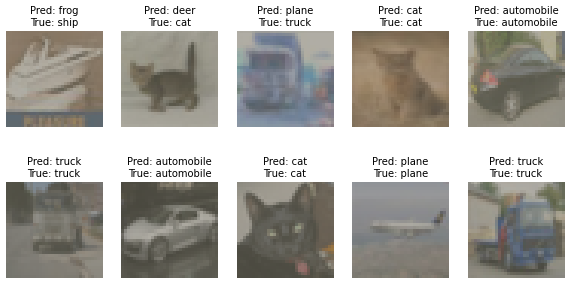

In [33]:
# Function to show images with predictions
def show_predictions(loader, net, class_names, num_images=10):
    net.eval()
    dataiter = iter(loader)
    images, labels = next(dataiter)

 # Perform predictions
    with torch.no_grad():
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)

    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2023, 0.1994, 0.2010])

    # Plot images
    plt.figure(figsize=(12, 6), dpi=60)
    for i in range(num_images):
        plt.subplot(2, 5, i + 1)
        img = np.transpose(images[i].numpy(), (1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
        img = std * img + mean  # Denormalize image
        img = np.clip(img, 0, 1)
        plt.imshow(img)
        plt.title(f'Pred: {class_names[predicted[i]]}\nTrue: {class_names[labels[i]]}')
        plt.axis('off')

    plt.show()

show_predictions(test_loader, net, class_names, num_images=10)

In [32]:
new_transform = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

def load_image(image_path):
    image = Image.open(image_path)
    image = new_transform(image)
    image = image.unsqueeze(0)
    return image


image_paths = ['pic1.jpg']
images = [load_image(img) for img in image_paths]

net = NeuralNet()
net.load_state_dict(torch.load('trained.pth', map_location=torch.device('cpu'), weights_only=True))  # Load weights only
net.eval()
with torch.no_grad():
  for image in images:
    output = net(image)
    _, predicted = torch.max(output.data, 1)
    print(f'Prediction: {class_names[predicted.item()]}')


Prediction: bird
